In [2]:
import os
import numpy as np
import cv2
import random as rng

### Define dataset structure

The initial idea is to save the images whole, and let a get_batch function do the cutting and pairing when creating the batch. The strcuture of the dataset is going to be as follows:

* images
    * train
        * s000 (infered by the names of the images)
            * s000img1 (actually original name of the image)
            * s000img2
            * ...
        * S001 
            * etc.
    * valid
        * s700
            * etc.
    * test
        * s999
            * etc.

For now, i will skip this structure creation and just assume it, for the experimenting enviroment, I will upload a few pictures and manually define this structure, and just work with train.

In [3]:
!pwd

/home/projects/marss-ml-jupylab/src/eurecom/studprojskrabec


In [16]:
STRIP_SIZE = 256

Right now im storing the images whole. With the strips dictionary, given a strip we can get the image location and the pixels of the strip.
However, in practice, this means that an image may be read multiple times when generating batches, also, it means that we read a whole big-ass image, while only needing a small part of it. A better approach would be to store the strips already as separate images beforehand, which unfortunately may increase the dataset size.

In [25]:
def get_dataset(base_path = "images", s = "train", strips_device = 4, strip_size = 256):
    devices = {}
    strips = {}
    s_path = os.path.join(base_path, s)
    strip_num = 0
    for device in os.scandir(s_path):
        if len(device.name) != 3:
            continue
        d_num = int(device.name)
        devices[d_num] = device.path
#        imgs = os.listdir(device)
        for strip in range(strips_device): #I'm only taking 4 strips for image. (top-left 4) and assuming I always can 
            x = strip * strip_size         #Better logic should be impl. to get the max. amount of strips per img size
            y = 0                        
            strips[strip_num] = (d_num, x, y)
            strip_num += 1
    return devices, strips

In [31]:
d, s = get_dataset()

In [32]:
print(s)
print(d)

{0: (101, 0, 0), 1: (101, 256, 0), 2: (101, 512, 0), 3: (101, 768, 0), 4: (100, 0, 0), 5: (100, 256, 0), 6: (100, 512, 0), 7: (100, 768, 0), 8: (102, 0, 0), 9: (102, 256, 0), 10: (102, 512, 0), 11: (102, 768, 0)}
{101: 'images/train/101', 100: 'images/train/100', 102: 'images/train/102'}


In [119]:
def get_batch(batch_size, devices, strips, imgids = False):
    #choose at random some categories (category = strip location of a given device)
    categories = rng.sample(range(0, len(strips)), k=batch_size)
    
    pairs = [np.zeros((batch_size, STRIP_SIZE, STRIP_SIZE, 3)) for i in range(2)]
    labels = np.zeros((batch_size, ))
    ids = []
    
    #the first half of the batch will be positive examples and the second negative
    labels[batch_size//2:] = 1
    for i in range(batch_size):
        cat = categories[i]
        x = strips[cat][1] # x position of the strip
        y = strips[cat][2] # y position of the strip
        imgs_paths = [os.path.join(devices[strips[cat][0]], l) for l in os.listdir(devices[strips[cat][0]])]
        if i >= batch_size // 2:
            idxs = rng.sample(range(0, len(imgs_paths)-1), k=2)
            img1 = cv2.imread(imgs_paths[idxs[0]])
            img2 = cv2.imread(imgs_paths[idxs[1]])
            pairs[0][i,:,:,:] = img1[x:x+STRIP_SIZE, y:y+STRIP_SIZE, :]
            pairs[1][i,:,:,:] = img2[x:x+STRIP_SIZE, y:y+STRIP_SIZE, :]
            ids.append((imgs_paths[idxs[0]], cat, imgs_paths[idxs[1]], cat))
        else :
            idx1 = rng.randint(0, len(imgs_paths)-1)
            cat2 = (cat + rng.randint(1, len(categories))) % len(categories) # we ensure that is a different category
            x2 = strips[cat2][1]
            y2 = strips[cat2][2]            
            imgs_paths2 = [os.path.join(devices[strips[cat2][0]], l) for l in os.listdir(devices[strips[cat2][0]])]
            idx2 = rng.randint(0, len(imgs_paths2)-1)
            img1 = cv2.imread(imgs_paths[idx1])
            img2 = cv2.imread(imgs_paths2[idx2])
            pairs[0][i,:,:,:] = img1[x:x+STRIP_SIZE, y:y+STRIP_SIZE, :]
            pairs[1][i,:,:,:] = img2[x2:x2+STRIP_SIZE, y2:y2+STRIP_SIZE, :]
            ids.append((imgs_paths[idx1], cat, imgs_paths[idx2], cat2))
            
    if imgids:
        return pairs, labels, ids
    return pairs, labels

In [72]:
import matplotlib.pyplot as plt

TypeError: must be str, not numpy.float64

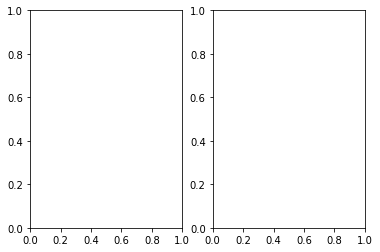

In [128]:
pairs, labels, ids = get_batch(4,d ,s, True)
for ix, i  in enumerate(ids):
    f, ax = plt.subplots(1,2)
    f.suptitle("Pair" + str(labels[ix]) )
    ax[0].imshow(pairs[0][ix,:,:,::-1]/255)
    title = str(s[i[1]]) + "\n" +  i[0].split('/')[-1] 
    ax[0].set_title(title)
    ax[1].imshow(pairs[1][ix,:,:,::-1]/255)
    title = str(s[i[3]]) + "\n" +  i[2].split('/')[-1] 
    ax[1].set_title(title)